In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## PART A

### Feature Engineering

In [2]:
# Loading the required dataset
medical_data = pd.read_csv("dataset_diabetes/diabetic_data.csv",na_values="?",low_memory=False)
medical_data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [3]:
# Dimension of the original dataset
print("The Dataset consists of {} instances and {} features".format(*medical_data.shape))

The Dataset consists of 101766 instances and 50 features


#### Handling Missing values

In [4]:
medical_data.dtypes.value_counts()

object    37
int64     13
dtype: int64

In [5]:
# The missing value percentage of each columns
print("Columns with missing values.")
missing=pd.DataFrame((((medical_data.isna().apply(sum))/101766)*100).apply(lambda x:round(x,ndigits=2)).sort_values(ascending = False),columns=["Missing value %"])
missing.index.set_names("Features",inplace = True)
missing[missing["Missing value %"] >0]

Columns with missing values.


,Missing value %
Features,
weight,96.86
medical_specialty,49.08
payer_code,39.56
race,2.23
diag_3,1.40
diag_2,0.35
diag_1,0.02


##### It is found that the columns "weight", "payer_code" and "medical_specialty" have a high percentage of missing values and hence are being dropped.

In [6]:
# Dropping columns with high percentage of missing values
medical_data.drop(columns=["weight","payer_code","medical_specialty"],inplace= True)

##### "encounter_id" column is also dropped because it has a unique value for each instance of data and does not provide any information of the target variable.

In [7]:
# Dropping column encounter_id
print("Unique values in column encounter_id: {}\nNumber of values in column encounter_id: {}".
      format(len(medical_data["encounter_id"].unique()),len(medical_data["encounter_id"])))
print("Hence being dropped")
medical_data.drop(columns=["encounter_id"],inplace= True)

Unique values in column encounter_id: 101766
Number of values in column encounter_id: 101766
Hence being dropped


In [8]:
# Splliting the dataset into features and target

X = medical_data.iloc[:,:-1] # Features
Y = medical_data.iloc[:,-1] # Target variabels

Y=Y.apply(lambda x: 1 if x != "NO" else 0)

In [9]:
# # Filling in all the missing values remaining

# # Using simple imputer and filling in the most frequtn values inplace of nan
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy= "most_frequent")
filled_X= imputer.fit_transform(X)

# Assigning filled values
X.iloc[:,:]=filled_X


#### Feature Transformation

In [10]:
# Converting categorical variables into numerical variables 

from sklearn.preprocessing import OrdinalEncoder

def gender_encoding (a):
    """
    Input: Gender value    
    Output: Encoded gender value
    
    Function to encode Male as 1, Female as -1 
    and Other as 0    
    """
    # Returning encoded values
    if a ==  "Male":
        return 1
    elif a == "Female":
        return -1
    else:
        return 0

def medicine_status_encoding(b):
    """
    Input: Medicine status    
    Output: Encoded Medicine value
    
    Function to encode Up as 2, down as 1,
    no as -1 and steady as 0
    
    """
    # Returning encoded values
    if b == "Up":
        return 2
    elif b == "Down":
        return 1
    elif b == "Steady":
        return 0
    elif b == "No":
        return -1
    
def cat_to_num(X, to_ordinal =[],medicines = []):
    '''
    Input:  X - original dataset
            to_ordinal  - the columns that need to be oridinal encoded
            medicines = The columns containing medicine status 
    
    Output: X - after all the processing done
    
    Function to change the categorical variables present in 
    the dataset to encoded numericals  
    
    '''
    Oren = OrdinalEncoder(dtype = np.int64)
    n = X.shape[1]
    # looping through the columns and encodering the categorical column     
    for i in range(n):
        
        # Ordinal encoding for ordinal columns
        if X.iloc[:,i].name in to_ordinal:
            X.loc[:,X.iloc[:,i].name] = Oren.fit_transform(X.iloc[:,[i]])
            
        # Gender encoding the gender columns
        elif X.iloc[:,i].name == "gender":
            X[X.iloc[:,i].name] = X[X.iloc[:,i].name].apply(gender_encoding) 
        
        # Encoding the medcine status
        elif X.iloc[:,i].name in medicines:
            X[X.iloc[:,i].name] = X[X.iloc[:,i].name].apply(medicine_status_encoding)         
    
    return X



# Defining the columns to be ordinal encoded and columns with medicine status
medicine_columns = X.iloc[:,20:-2].columns
ordinal_columns = ["patient_nbr","race","age","diag_1","diag_2","diag_3","max_glu_serum","A1Cresult","change","diabetesMed"]

# Converting all the categorical variables to encoded numericals
X = cat_to_num(X,to_ordinal=ordinal_columns,medicines=medicine_columns)


In [11]:
# Performing Data normalization
from sklearn.preprocessing import StandardScaler

normalizer = StandardScaler()

X.iloc[:,:] = normalizer.fit_transform(X)

In [12]:
# Data after normalization
X.head()

,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
0,-1.222446,0.391474,-0.927438,-3.824600,2.750800,4.031022,-1.169873,-1.137649,-0.106517,-0.785398,...,0.0,0.0,-0.870219,-0.081566,-0.011303,-0.003135,-0.004433,-0.003135,0.926591,-1.829868
1,0.132405,0.391474,-0.927438,-3.197277,-0.708461,-0.514312,0.306482,-0.467653,0.808384,-0.785398,...,0.0,0.0,2.107113,-0.081566,-0.011303,-0.003135,-0.004433,-0.003135,-1.079225,0.546488
2,0.828245,-1.951156,-0.927438,-2.569954,-0.708461,-0.514312,0.306482,-0.802651,-1.631351,2.145781,...,0.0,0.0,-0.870219,-0.081566,-0.011303,-0.003135,-0.004433,-0.003135,0.926591,0.546488
3,0.695713,0.391474,1.078271,-1.942632,-0.708461,-0.514312,0.306482,-0.802651,0.045967,-0.199162,...,0.0,0.0,2.107113,-0.081566,-0.011303,-0.003135,-0.004433,-0.003135,-1.079225,0.546488
4,-0.156937,0.391474,1.078271,-1.315309,-0.708461,-0.514312,0.306482,-1.137649,0.401761,-0.785398,...,0.0,0.0,0.122225,-0.081566,-0.011303,-0.003135,-0.004433,-0.003135,-1.079225,0.546488


In [13]:
# Splitting the Dataset into testing and trainig datasets
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,Y, test_size = .25,random_state = 123)

### Supervised Learning

### Task 1

### Model Traning

In [14]:
# Training Multi layer preceptron classifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate

MLP_model = MLPClassifier(hidden_layer_sizes=(128,64,32),max_iter=500,learning_rate_init=.003)
MLP_results = cross_validate(MLP_model,X_train,y_train,cv = 10,return_estimator= True)

In [15]:
# Training K nearest neighbour classifier classifier
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors = 20,n_jobs=-1)
knn_results = cross_validate(knn_model,X_train,y_train,cv = 10,return_estimator= True)

In [16]:
# Training Decision Tree classifier
from sklearn.tree import DecisionTreeClassifier

DT_model = DecisionTreeClassifier(max_depth=15,random_state=3,)
DT_results = cross_validate(DT_model,X_train,y_train,cv = 10,return_estimator= True)

In [17]:
# Training Navies Bayesian classifier
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_results = cross_validate(nb_model,X_train,y_train,cv = 10,return_estimator= True)

In [18]:
# Training Extreme tress classifier
from sklearn.ensemble import ExtraTreesClassifier

et_model = ExtraTreesClassifier(random_state=123,n_jobs=-1)
et_results = cross_validate(et_model,X_train,y_train,cv = 10,return_estimator= True)

### Model evaluation

In [19]:
# Loading the models
mlp_model = MLP_results["estimator"][-1]
dt_model  = DT_results["estimator"][-1]
nb_model  = nb_results["estimator"][-1]
knn_model = knn_results["estimator"][-1]
et_model  = et_results["estimator"][-1]

In [20]:
from sklearn.metrics import recall_score,f1_score,ConfusionMatrixDisplay,confusion_matrix,classification_report 
from math import ceil
from time import gmtime,strftime

# Function to evaluate f1_measure,recall and specificity
def evaluation_metrics(estimator,X,Y):
    """
    Input : estimator - the model that needs to be evaluated
            X - The test dataset
            Y - the test target variable
            
    Output : dict containing F1_score,sensitivity and specificity
    """
    prediction = estimator.predict(X)
    report = classification_report(Y,prediction,output_dict=True)
    recall = round(report['1']['recall'],4)
    f1 = round(report['1']['f1-score'],4)
    spec = round(report['0']['recall'],4)

    metrics = {"f1_score":f1,"Recall":recall,"Specificity":spec}
    return metrics

In [21]:
# Calculating F1-measure,recall specificity for the 5 models
MLP_metrics = evaluation_metrics(mlp_model,X_test,y_test)
knn_metrics = evaluation_metrics(knn_model,X_test,y_test)
DT_metrics = evaluation_metrics(dt_model,X_test,y_test)
nb_metrics = evaluation_metrics(nb_model,X_test,y_test)
et_metrics = evaluation_metrics(et_model,X_test,y_test)

In [22]:
# Calculating the runtime for the 5 models
MLP_metrics["runtime"] = strftime("%M min %S secs",gmtime(ceil(np.mean(MLP_results["fit_time"]))))
knn_metrics["runtime"] = strftime("%M min %S secs",gmtime(ceil(np.mean(knn_results["fit_time"]))))
DT_metrics["runtime"] = strftime("%M min %S secs",gmtime(ceil(np.mean(DT_results["fit_time"]))))
nb_metrics["runtime"] = strftime("%M min %S secs",gmtime(ceil(np.mean(nb_results["fit_time"]))))
et_metrics["runtime"] = strftime("%M min %S secs",gmtime(ceil(np.mean(et_results["fit_time"]))))

In [23]:
# Calaculating the accuracy of the 5 models
MLP_metrics["accuracy"] = round(mlp_model.score(X_test,y_test),4)
knn_metrics["accuracy"] = round(knn_model.score(X_test,y_test),4)
DT_metrics["accuracy"] = round(dt_model.score(X_test,y_test),4)
nb_metrics["accuracy"] = round(nb_model.score(X_test,y_test),4)
et_metrics["accuracy"] = round(et_model.score(X_test,y_test),4)

### ROC curves

In [24]:
from sklearn.metrics import RocCurveDisplay,roc_curve,roc_auc_score

In [25]:
# Function to plot roc and calculate area under roc
def AUC_ROC(estimator,test_data,test_target):
    """
    Input: estimator - the model
           test_data - test dataset features
           test_target - test dataset target
           
    Output: fpr - False positive rate
            tpr - True positive rate
            auc - area under roc
    
    """
    y_pred = estimator.predict_proba(test_data)[:,1]
    fpr,tpr,_= roc_curve(test_target,y_pred,pos_label=1)
    auc = roc_auc_score(test_target,y_pred)
    
    # Plotting the figure
    fig= plt.figure(figsize=(7,5))
    axes=fig.add_axes([1,1,1,1])
    RocCurveDisplay(fpr=fpr,tpr=tpr).plot(ax = axes,lw = 2)
    axes.set_title("ROC curve ")
    plt.show()
    
    return fpr,tpr,auc

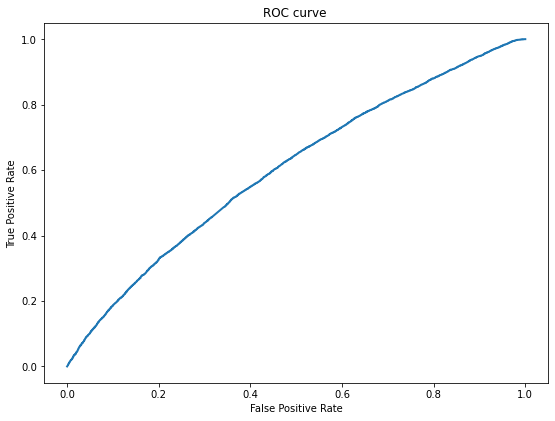

In [26]:
# Plotting ROC and calculating area under roc for Multi Layer preceptron
MLP_fpr,MLP_tpr,MLP_auc= AUC_ROC(mlp_model,X_test,y_test)
MLP_metrics["AUC"] = round(MLP_auc,4)

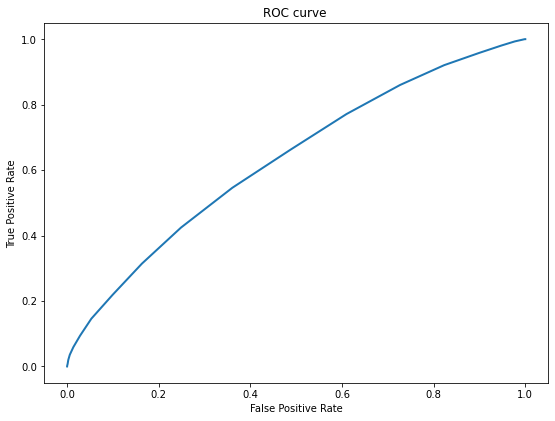

In [27]:
# Plotting ROC and calculating area under roc for K nearest neighbors
knn_fpr,knn_tpr,knn_auc= AUC_ROC(knn_model,X_test,y_test)
knn_metrics["AUC"] = round(knn_auc,4)

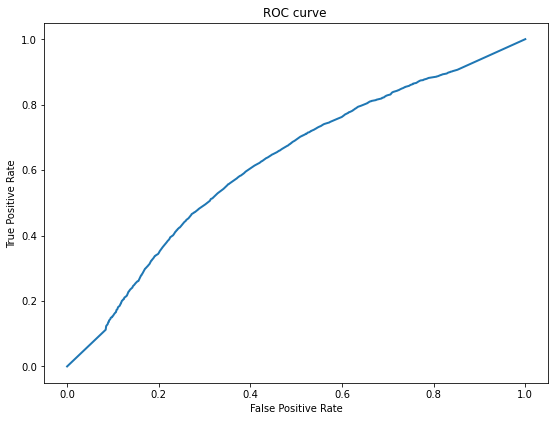

In [28]:
# Plotting ROC and calculating area under roc for Decision tress classifier
dt_fpr,dt_tpr,dt_auc= AUC_ROC(dt_model,X_test,y_test)
DT_metrics["AUC"] = round(dt_auc,4)

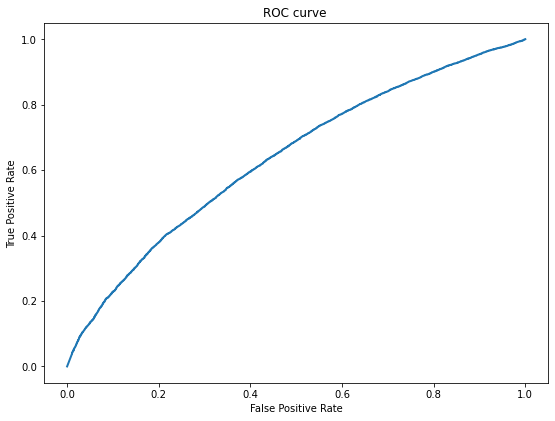

In [29]:
# Plotting ROC and calculating area under roc for Navies bayesian classifier
nb_fpr,nb_tpr,nb_auc= AUC_ROC(nb_model,X_test,y_test)
nb_metrics["AUC"] = round(nb_auc,4)

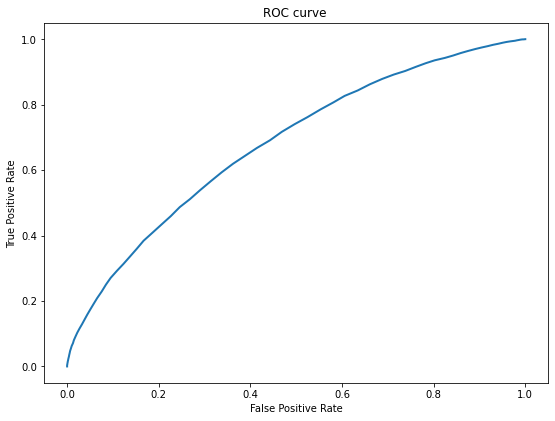

In [30]:
# Plotting ROC and calculating area under roc for Extreme learning trees
et_fpr,et_tpr,et_auc= AUC_ROC(et_model,X_test,y_test)
et_metrics["AUC"] = round(et_auc,4)

In [31]:
# Merging the metrics of the all the models
evaluation_data=np.c_[list(MLP_metrics.values()),
                    list(knn_metrics.values()),
                    list(DT_metrics.values()),
                    list(nb_metrics.values()),
                    list(et_metrics.values())]

# Defining the index and columns of the dataset
models=["MLP","KNN",'DT',"NB","ELT"]
metric = MLP_metrics.keys()

# Creating the metric table
metrics_table = pd.DataFrame(evaluation_data,columns=models,index = metric)
metrics_table

,MLP,KNN,DT,NB,ELT
f1_score,0.5421,0.4958,0.5707,0.6337,0.5614
Recall,0.539,0.4244,0.5663,0.9997,0.5111
Specificity,0.6112,0.7514,0.6383,0.0007,0.732
runtime,08 min 54 secs,01 min 05 secs,00 min 02 secs,00 min 01 secs,00 min 21 secs
accuracy,0.5777,0.5997,0.6049,0.464,0.6295
AUC,0.6035,0.6317,0.622,0.6373,0.6802


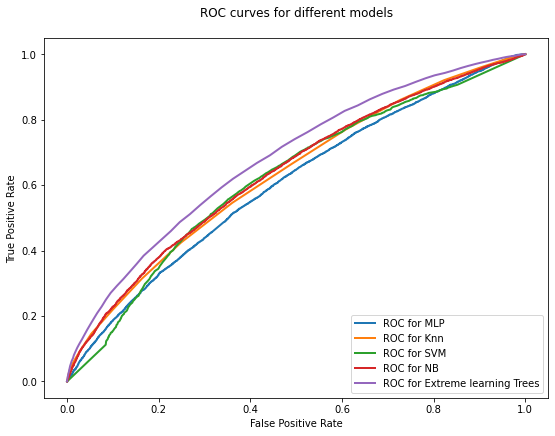

In [32]:
# Plotting ROC  curves of all the models to contrast each other
fig= plt.figure(figsize=(7,5))
axes=fig.add_axes([1,1,1,1])
RocCurveDisplay(fpr=MLP_fpr,tpr=MLP_tpr).plot(ax = axes,label = 'ROC for MLP',lw = 2)
RocCurveDisplay(fpr=knn_fpr,tpr=knn_tpr).plot(ax = axes,label = 'ROC for Knn',lw = 2)
RocCurveDisplay(fpr=dt_fpr,tpr=dt_tpr).plot(ax = axes,label = 'ROC for SVM',lw = 2)
RocCurveDisplay(fpr=nb_fpr,tpr=nb_tpr).plot(ax = axes,label = 'ROC for NB',lw = 2)
RocCurveDisplay(fpr=et_fpr,tpr=et_tpr).plot(ax = axes,label = 'ROC for Extreme learning Trees',lw = 2)
axes.set_title("ROC curves for different models\n",)
plt.show()

### Statistical Analysis

In [33]:
# Merging the test scores from cross validation into one array
Kflod_scores = np.c_[MLP_results["test_score"],
        knn_results["test_score"],
        DT_results["test_score"],
        nb_results["test_score"],
        et_results["test_score"]]

# Calculating the mean and standard deviation and merging it
Kflod_scores_final = np.r_[Kflod_scores,
                     np.mean(Kflod_scores,axis=0).reshape((1,5)),
                     np.std(Kflod_scores,axis=0).reshape((1,5))]

# Declaring Columns and index
models=["MLP","KNN",'DT',"NB","ELT"]
fold_index = [*range(1,11),"Average Accuracy(mean)","Standard deviation"]

# Creating a table using all the results
K_fold_table = pd.DataFrame(Kflod_scores_final,columns=models,index = fold_index)
K_fold_table.index.set_names("Folds",inplace= True)
K_fold_table.columns.set_names("Algorithm",inplace= True)

# Displaying the table
K_fold_table.style.set_properties(**{"text-align" : "center"})
K_fold_table.style.set_properties(pd.IndexSlice[10],**{"border-bottom" : "solid","border-width": "2px"})

Algorithm,MLP,KNN,DT,NB,ELT
Folds,,,,,
1,0.601336,0.603301,0.609459,0.459976,0.638019
2,0.592297,0.602122,0.609983,0.460107,0.640115
3,0.579196,0.592297,0.597537,0.583519,0.633434
4,0.596882,0.602777,0.613127,0.460238,0.637757
5,0.589623,0.597615,0.610980,0.460430,0.642820
6,0.599319,0.602332,0.614256,0.460037,0.642427
7,0.587526,0.592374,0.601808,0.583333,0.629062
8,0.588181,0.604036,0.609932,0.585430,0.643999
9,0.589230,0.600629,0.615959,0.460037,0.643606


In [34]:
from scipy.stats import ttest_rel

def calculate_p_values(data):
    '''
    Input:
        data: 
            Data obtained from crossvalidation fro the models in consideration
    Output:
        p_values: 
            The p_values obtained when performing paired t-test on the models in consideration
        differences: 
            The Dataframe show results of the paired t-test and comparisions
    
    Function to perform t_test and calculate p-value 
    '''
    # Declaring Necessary variables
    p_values = list()
    mem = list()
    differences = list()
    models = list()
    
    # Performing t-test on all the models
    for i in range(data.shape[1]-1):
        for j in range(data.shape[1]):
            if i!=j:
                if ((j,i) not in mem):
                    
                    # Performing t-test on odel a and b
                    a,b =data.iloc[:,i],data.iloc[:,j]
                    _,p_value = ttest_rel(a,b)
                    
                    differences.append(np.array(a-b)) # appending difference between accuracy of model a and b in the ten folds
                    p_values.append(p_value) # appending p_value from the t-test
                    mem.append((i,j)) # appending the combination compared avoid repetition
                    models.append(data.iloc[:,i].name+"-"+data.iloc[:,j].name) # appeding names for columns
    
    # Merges the Data collected and Statistics on the data
    differences = np.c_[differences].T
    differences = np.r_[differences,
                        np.mean(differences,axis=0).reshape((1,differences.shape[1])),
                        np.std(differences,axis=0).reshape((1,differences.shape[1])),
                        np.array(p_values).reshape((1,differences.shape[1]))]
    # Creating Dataframe
    index = [*range(1,11),"Average Accuracy(mean)","Standard Deviation","p-value"]
    differences = pd.DataFrame(differences,index=index,columns=models)
    differences.index.set_names("Fold",inplace=True)
    differences.columns.set_names("Accuracy Difference",inplace=True)
    
    
    return p_values,differences
# Calculating p_values and creating the table required
p_values,statistics= calculate_p_values(K_fold_table.iloc[:10,:])

In [35]:
# Displaying statistics
statistics

Accuracy Difference,MLP-KNN,MLP-DT,MLP-NB,MLP-ELT,KNN-DT,KNN-NB,KNN-ELT,DT-NB,DT-ELT,NB-ELT
Fold,,,,,,,,,,
1,-0.001965,-0.008123,0.141360,-3.668282e-02,-0.006157,0.143325,-3.471767e-02,0.149483,-2.856020e-02,-0.178043
2,-0.009826,-0.017686,0.132189,-4.781868e-02,-0.007861,0.142015,-3.799293e-02,0.149876,-3.013232e-02,-0.180008
3,-0.013101,-0.018341,-0.004323,-5.423818e-02,-0.005240,0.008778,-4.113717e-02,0.014018,-3.589676e-02,-0.049915
4,-0.005895,-0.016245,0.136644,-4.087515e-02,-0.010350,0.142539,-3.497969e-02,0.152889,-2.462990e-02,-0.177519
5,-0.007993,-0.021357,0.129193,-5.319706e-02,-0.013365,0.137186,-4.520440e-02,0.150550,-3.183962e-02,-0.182390
6,-0.003014,-0.014937,0.139282,-4.310797e-02,-0.011923,0.142296,-4.009434e-02,0.154219,-2.817086e-02,-0.182390
7,-0.004848,-0.014282,0.004193,-4.153564e-02,-0.009434,0.009041,-3.668763e-02,0.018475,-2.725367e-02,-0.045729
8,-0.015854,-0.021751,0.002752,-5.581761e-02,-0.005896,0.018606,-3.996331e-02,0.024502,-3.406709e-02,-0.058569
9,-0.011399,-0.026730,0.129193,-5.437631e-02,-0.015330,0.140592,-4.297694e-02,0.155922,-2.764675e-02,-0.183569


In [36]:
# the pairs of models with statistical significant difference
print("From the table it is clear that there is statistical significant difference between the following models:\n")

for x,y in zip(statistics.columns.values,p_values):
    if y < 0.005:
        algo=x.split("-")
        print("{} and {}".format(algo[0],algo[1]))

From the table it is clear that there is statistical significant difference between the following models:

MLP and KNN
MLP and DT
MLP and NB
MLP and ELT
KNN and DT
KNN and NB
KNN and ELT
DT and NB
DT and ELT
NB and ELT


## Task 2

In [37]:
# Treating the insuling column as target variable
a = medical_data.columns.get_loc("insulin")

X_2 = medical_data.iloc[:,:a].join(medical_data.iloc[:,a+1:])
Y_2 = medical_data.iloc[:,a]

In [38]:
# Filling in all the missing values remaining

# Using simple imputer and filling in the most frequtn values inplace of nan
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy= "most_frequent")
filled_X_2= imputer.fit_transform(X_2)

# Assigning filled values
X_2.iloc[:,:]=filled_X_2

In [39]:
# Defining the columns to be ordinal encoded and columns with medicine status
medicine_columns = X_2.iloc[:,20:-3].columns
ordinal_columns = ["patient_nbr","race","age","diag_1","diag_2","diag_3","max_glu_serum","A1Cresult","change","diabetesMed","readmitted"]

# Converting all the categorical variables to encoded numericals
X_2 = cat_to_num(X_2,to_ordinal=ordinal_columns,medicines=medicine_columns)

In [40]:
# Performing Data normalization
from sklearn.preprocessing import StandardScaler

normalizer = StandardScaler()

X_2.iloc[:,:] = normalizer.fit_transform(X_2)

In [41]:
X_2

,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,...,examide,citoglipton,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,-1.222446,0.391474,-0.927438,-3.824600,2.750800,4.031022,-1.169873,-1.137649,-0.106517,-0.785398,...,0.0,0.0,-0.081566,-0.011303,-0.003135,-0.004433,-0.003135,0.926591,-1.829868,0.83688
1,0.132405,0.391474,-0.927438,-3.197277,-0.708461,-0.514312,0.306482,-0.467653,0.808384,-0.785398,...,0.0,0.0,-0.081566,-0.011303,-0.003135,-0.004433,-0.003135,-1.079225,0.546488,-0.62497
2,0.828245,-1.951156,-0.927438,-2.569954,-0.708461,-0.514312,0.306482,-0.802651,-1.631351,2.145781,...,0.0,0.0,-0.081566,-0.011303,-0.003135,-0.004433,-0.003135,0.926591,0.546488,0.83688
3,0.695713,0.391474,1.078271,-1.942632,-0.708461,-0.514312,0.306482,-0.802651,0.045967,-0.199162,...,0.0,0.0,-0.081566,-0.011303,-0.003135,-0.004433,-0.003135,-1.079225,0.546488,0.83688
4,-0.156937,0.391474,1.078271,-1.315309,-0.708461,-0.514312,0.306482,-1.137649,0.401761,-0.785398,...,0.0,0.0,-0.081566,-0.011303,-0.003135,-0.004433,-0.003135,-1.079225,0.546488,0.83688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,1.288506,-1.951156,1.078271,0.566659,-0.708461,-0.135535,0.306482,-0.467653,0.401761,-0.785398,...,0.0,0.0,-0.081566,-0.011303,-0.003135,-0.004433,-0.003135,-1.079225,0.546488,-0.62497
101762,0.563960,-1.951156,-0.927438,1.193982,-0.708461,0.053854,-0.185636,0.202343,-0.513139,0.973309,...,0.0,0.0,-0.081566,-0.011303,-0.003135,-0.004433,-0.003135,0.926591,0.546488,0.83688
101763,-0.245632,0.391474,1.078271,0.566659,-0.708461,-0.514312,0.306482,-1.137649,0.503417,-0.785398,...,0.0,0.0,-0.081566,-0.011303,-0.003135,-0.004433,-0.003135,-1.079225,0.546488,0.83688
101764,-0.486953,0.391474,-0.927438,1.193982,-0.016609,-0.135535,0.306482,1.877333,0.096794,0.387074,...,0.0,0.0,-0.081566,-0.011303,-0.003135,-0.004433,-0.003135,-1.079225,0.546488,0.83688


In [42]:
# Splitting the Dataset into testing and trainig datasets
from sklearn.model_selection import train_test_split

X_train_2,X_test_2,y_train_2,y_test_2 = train_test_split(X_2,Y_2, test_size = .25,random_state = 1)

### Model Training

In [43]:
# Training Multi layer preceptron classifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate

MLP_model_2 = MLPClassifier(hidden_layer_sizes=(128,64,32),max_iter=500,learning_rate_init=.003)
MLP_results_2 = cross_validate(MLP_model_2,X_train_2,y_train_2,cv = 10,return_estimator= True)

In [44]:
# Training K nearest neighbour classifier classifier
from sklearn.neighbors import KNeighborsClassifier

knn_model_2 = KNeighborsClassifier(n_neighbors = 20,n_jobs=-1)
knn_results_2 = cross_validate(knn_model_2,X_train_2,y_train_2,cv = 10,return_estimator= True)

In [45]:
# Training Decision Tree classifier
from sklearn.tree import DecisionTreeClassifier

DT_model_2 = DecisionTreeClassifier(max_depth=15,random_state=3,)
DT_results_2 = cross_validate(DT_model_2,X_train_2,y_train_2,cv = 10,return_estimator= True)

In [46]:
# Training Navies Bayesian classifier
from sklearn.naive_bayes import GaussianNB

nb_model_2 = GaussianNB()
nb_results_2 = cross_validate(nb_model_2,X_train_2,y_train_2,cv = 10,return_estimator= True)

In [47]:
# Training Extreme tress classifier
from sklearn.ensemble import ExtraTreesClassifier

et_model_2 = ExtraTreesClassifier(random_state=123,n_jobs=-1)
et_results_2 = cross_validate(et_model_2,X_train_2,y_train_2,cv = 10,return_estimator= True)

### Model evaluation

In [48]:
# Loading the models
mlp_model_2 = MLP_results_2["estimator"][-1]
dt_model_2  = DT_results_2["estimator"][-1]
nb_model_2  = nb_results_2["estimator"][-1]
knn_model_2 = knn_results_2["estimator"][-1]
et_model_2  = et_results_2["estimator"][-1]

In [49]:
from sklearn.metrics import recall_score,f1_score,confusion_matrix 
from time import gmtime,strftime
from math import ceil

# Function to evaluate f1_measure,recall and specificity for multi-class 
def evaluation_metrics_multi(estimator,X,Y):
    """
    Input : estimator - the model that needs to be evaluated
            X - The test dataset
            Y - the test target variable
            
    Output : dict containing F1_score,sensitivity and specificity
    """
    prediction = estimator.predict(X)
    classes=estimator.classes_
    recall = recall_score(Y,prediction,average='macro',labels=classes)
    f1 = f1_score(Y,prediction,average='macro',labels=classes)
    cn = confusion_matrix(Y,prediction)
    False_Positive = cn.sum(axis=0) - np.diag(cn)  
    False_negative = cn.sum(axis=1) - np.diag(cn)
    True_Positive = np.diag(cn)
    True_negative = cn.sum() - (False_negative + False_Positive + True_Positive)
    spec = np.mean(True_negative/(True_negative+False_Positive))

    metrics = {"f1_score":f1,"Recall":recall,"Specificity":spec}
    return metrics

In [50]:
# Calculating F1-measure,recall specificity for the 5 models
MLP_metrics_2 = evaluation_metrics_multi(mlp_model_2,X_test_2,y_test_2)
knn_metrics_2 = evaluation_metrics_multi(knn_model_2,X_test_2,y_test_2)
DT_metrics_2 = evaluation_metrics_multi(dt_model_2,X_test_2,y_test_2)
nb_metrics_2 = evaluation_metrics_multi(nb_model_2,X_test_2,y_test_2)
et_metrics_2 = evaluation_metrics_multi(et_model_2,X_test_2,y_test_2)

In [51]:
# Calculating the runtime for the 5 models
MLP_metrics_2["runtime"] = strftime("%M min %S secs",gmtime(ceil(np.mean(MLP_results_2["fit_time"]))))
knn_metrics_2["runtime"] = strftime("%M min %S secs",gmtime(ceil(np.mean(knn_results_2["fit_time"]))))
DT_metrics_2["runtime"] = strftime("%M min %S secs",gmtime(ceil(np.mean(DT_results_2["fit_time"]))))
nb_metrics_2["runtime"] = strftime("%M min %S secs",gmtime(ceil(np.mean(nb_results_2["fit_time"]))))
et_metrics_2["runtime"] = strftime("%M min %S secs",gmtime(ceil(np.mean(et_results_2["fit_time"]))))

In [52]:
# Calaculating the accuracy of the 5 models
MLP_metrics_2["accuracy"] = round(mlp_model_2.score(X_test_2,y_test_2),4)
knn_metrics_2["accuracy"] = round(knn_model_2.score(X_test_2,y_test_2),4)
DT_metrics_2["accuracy"] = round(dt_model_2.score(X_test_2,y_test_2),4)
nb_metrics_2["accuracy"] = round(nb_model_2.score(X_test_2,y_test_2),4)
et_metrics_2["accuracy"] = round(et_model_2.score(X_test_2,y_test_2),4)

### ROC curves

In [53]:
from sklearn.metrics import RocCurveDisplay,roc_curve,auc
from sklearn.preprocessing import label_binarize

In [54]:
# Function to plot roc and calculate area under roc for multi-class
def AUC_ROC_multi(estimator,test_data,test_target):
    
    y_pred = estimator.predict_proba(test_data)
    
    
    fpr = dict()
    tpr = dict()
    target=label_binarize(y_test_2,classes=estimator.classes_)
    no_of_classes = len(estimator.classes_)
    for i in range(no_of_classes):
        fpr[i],tpr[i],_= roc_curve(target[:,i],y_pred[:,i])
    
    # Collecting unique false positive rates
    unique_fpr = np.unique(np.concatenate([fpr[i] for i in range(no_of_classes )]))

    # Interpolating the points
    avg_tpr = np.zeros_like(unique_fpr)
    for i in range(no_of_classes):
        avg_tpr += np.interp(unique_fpr, fpr[i], tpr[i])
    
    # Calculating fpr and tpr
    fpr_m = unique_fpr
    tpr_m = avg_tpr /no_of_classes
    auc2 = auc(fpr_m,tpr_m)
    
    
    # Plotting the figure
    fig= plt.figure(figsize=(7,5))
    axes=fig.add_axes([1,1,1,1])
    RocCurveDisplay(fpr=fpr_m,tpr=tpr_m).plot(ax = axes,lw = 2)
    axes.set_title("ROC curve ")
    plt.show()
    
    return fpr_m,tpr_m,auc2

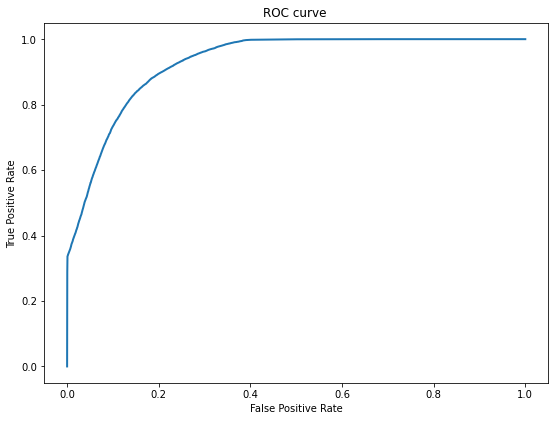

In [55]:
# Plotting ROC and calculating area under roc for Multi Layer preceptron
MLP_2_fpr,MLP_2_tpr,MLP_2_auc= AUC_ROC_multi(mlp_model_2,X_test_2,y_test_2)
MLP_metrics_2["AUC"] = round(MLP_2_auc,4)

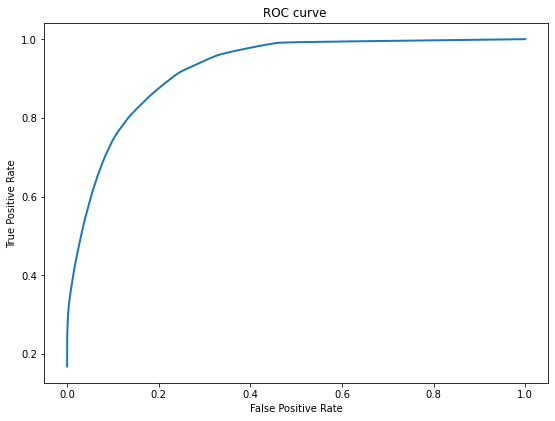

In [56]:
# Plotting ROC and calculating area under roc for K nearest neighbors
knn_2_fpr,knn_2_tpr,knn_2_auc= AUC_ROC_multi(knn_model_2,X_test_2,y_test_2)
knn_metrics_2["AUC"] = round(knn_2_auc,4)

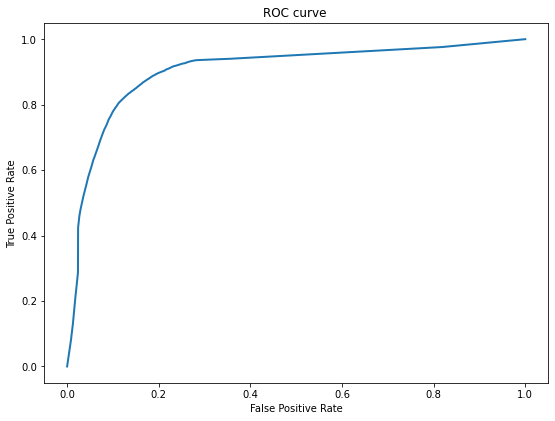

In [57]:
# Plotting ROC and calculating area under roc for Decision tress classifier
dt_2_fpr,dt_2_tpr,dt_2_auc= AUC_ROC_multi(dt_model_2,X_test_2,y_test_2)
DT_metrics_2["AUC"] = round(dt_2_auc,4)

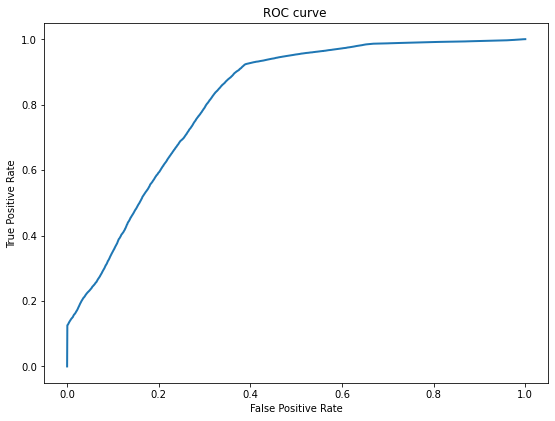

In [58]:
# Plotting ROC and calculating area under roc for Navies bayesian classifier
nb_2_fpr,nb_2_tpr,nb_2_auc= AUC_ROC_multi(nb_model_2,X_test_2,y_test_2)
nb_metrics_2["AUC"] = round(nb_2_auc,4)

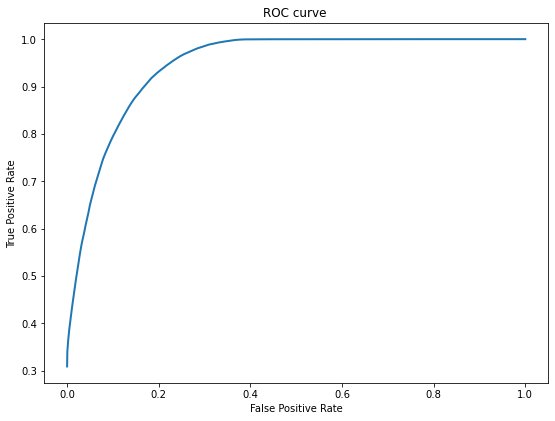

In [59]:
# Plotting ROC and calculating area under roc for Extreme learning trees
et_2_fpr,et_2_tpr,et_2_auc= AUC_ROC_multi(et_model_2,X_test_2,y_test_2)
et_metrics_2["AUC"] = round(et_2_auc,4)

In [60]:
# Merging the metrics of the all the models
evaluation_data_2=np.c_[list(MLP_metrics_2.values()),
                    list(knn_metrics_2.values()),
                    list(DT_metrics_2.values()),
                     list(nb_metrics_2.values()),
                    list(et_metrics_2.values())]

# Defining the index and columns of the dataset
models=["MLP","KNN",'DT',"NB","ELT"]
metric = MLP_metrics_2.keys()

# Creating the metric table
metrics_table_2 = pd.DataFrame(evaluation_data_2,columns=models,index = metric)
metrics_table_2

,MLP,KNN,DT,NB,ELT
f1_score,0.639631682127607,0.629305403742362,0.653034740167039,0.32610568572311277,0.6638487750154443
Recall,0.638837331450795,0.6223899411663344,0.6490531553643231,0.4599589000357284,0.655451283773315
Specificity,0.9232158381672899,0.91621173457466,0.9264187522493637,0.8277999653071809,0.9291537646792721
runtime,06 min 09 secs,01 min 00 secs,00 min 02 secs,00 min 01 secs,00 min 16 secs
accuracy,0.7703,0.7675,0.7873,0.4959,0.7964
AUC,0.9288,0.9233,0.9037,0.8139,0.9455


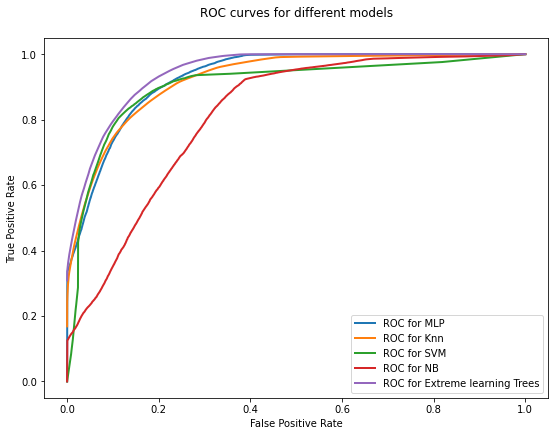

In [61]:
# Plotting ROC  curves of all the models to contrast each other
fig= plt.figure(figsize=(7,5))
axes=fig.add_axes([1,1,1,1])
RocCurveDisplay(fpr=MLP_2_fpr,tpr=MLP_2_tpr).plot(ax = axes,label = 'ROC for MLP',lw = 2)
RocCurveDisplay(fpr=knn_2_fpr,tpr=knn_2_tpr).plot(ax = axes,label = 'ROC for Knn',lw = 2)
RocCurveDisplay(fpr=dt_2_fpr,tpr=dt_2_tpr).plot(ax = axes,label = 'ROC for SVM',lw = 2)
RocCurveDisplay(fpr=nb_2_fpr,tpr=nb_2_tpr).plot(ax = axes,label = 'ROC for NB',lw = 2)
RocCurveDisplay(fpr=et_2_fpr,tpr=et_2_tpr).plot(ax = axes,label = 'ROC for Extreme learning Trees',lw = 2)
axes.set_title("ROC curves for different models\n",)
plt.show()

### Statistical analysis

In [62]:
# Merging the test scores from cross validation into one array
Kflod_scores_2 = np.c_[MLP_results_2["test_score"],
        knn_results_2["test_score"],
        DT_results_2["test_score"],
        nb_results_2["test_score"],
        et_results_2["test_score"]]

# Calculating the mean and standard deviation and merging it
Kflod_scores_final_2 = np.r_[Kflod_scores_2,
                     np.mean(Kflod_scores_2,axis=0).reshape((1,5)),
                     np.std(Kflod_scores_2,axis=0).reshape((1,5))]

# Declaring Columns and index
models_2=["MLP","KNN",'DT',"NB","ELT"]
fold_index_2 = [*range(1,11),"Average Accuracy(mean)","Standard deviation"]

# Creating a table using all the results
K_fold_table_2 = pd.DataFrame(Kflod_scores_final_2,columns=models_2,index = fold_index_2)
K_fold_table_2.index.set_names("Folds",inplace= True)
K_fold_table_2.columns.set_names("Algorithm",inplace= True)

# Displaying the table
K_fold_table_2.style.set_properties(**{"text-align" : "center"})
K_fold_table_2.style.set_properties(pd.IndexSlice[10],**{"border-bottom" : "solid","border-width": "2px"})

Algorithm,MLP,KNN,DT,NB,ELT
Folds,,,,,
1,0.765361,0.763527,0.775318,0.491026,0.794052
2,0.772304,0.763265,0.783571,0.494039,0.791301
3,0.759465,0.767195,0.781868,0.487358,0.791301
4,0.771911,0.776628,0.784750,0.494301,0.803485
5,0.769392,0.769130,0.777254,0.498428,0.791798
6,0.771882,0.763758,0.783412,0.492925,0.792977
7,0.770440,0.763889,0.776992,0.493580,0.795597
8,0.766378,0.767820,0.775419,0.508124,0.790356
9,0.765985,0.769261,0.781709,0.482573,0.794549


In [63]:
# Calculating p_values and creating the table required
p_values,statistics_2= calculate_p_values(K_fold_table_2.iloc[:10,:])

In [64]:
# Displaying statistics
statistics_2.round(4)

Accuracy Difference,MLP-KNN,MLP-DT,MLP-NB,MLP-ELT,KNN-DT,KNN-NB,KNN-ELT,DT-NB,DT-ELT,NB-ELT
Fold,,,,,,,,,,
1,0.0018,-0.0100,0.2743,-0.0287,-0.0118,0.2725,-0.0305,0.2843,-0.0187,-0.3030
2,0.0090,-0.0113,0.2783,-0.0190,-0.0203,0.2692,-0.0280,0.2895,-0.0077,-0.2973
3,-0.0077,-0.0224,0.2721,-0.0318,-0.0147,0.2798,-0.0241,0.2945,-0.0094,-0.3039
4,-0.0047,-0.0128,0.2776,-0.0316,-0.0081,0.2823,-0.0269,0.2904,-0.0187,-0.3092
5,0.0003,-0.0079,0.2710,-0.0224,-0.0081,0.2707,-0.0227,0.2788,-0.0145,-0.2934
6,0.0081,-0.0115,0.2790,-0.0211,-0.0197,0.2708,-0.0292,0.2905,-0.0096,-0.3001
7,0.0066,-0.0066,0.2769,-0.0252,-0.0131,0.2703,-0.0317,0.2834,-0.0186,-0.3020
8,-0.0014,-0.0090,0.2583,-0.0240,-0.0076,0.2597,-0.0225,0.2673,-0.0149,-0.2822
9,-0.0033,-0.0157,0.2834,-0.0286,-0.0124,0.2867,-0.0253,0.2991,-0.0128,-0.3120


In [65]:
# the pairs of models with statistical significant difference
print("From the table it is clear that there is statistical significant difference between the following models:\n")

for x,y in zip(statistics_2.columns.values,p_values):
    if y < 0.005:
        algo=x.split("-")
        print("{} and {}".format(algo[0],algo[1]))

From the table it is clear that there is statistical significant difference between the following models:

MLP and DT
MLP and NB
MLP and ELT
KNN and DT
KNN and NB
KNN and ELT
DT and NB
DT and ELT
NB and ELT


### Semi-supervised learning

In [66]:
# Splitting the Dataset into testing and trainig datasets
from sklearn.model_selection import train_test_split

X_train_s,X_test_s,y_train_s,y_test_s = train_test_split(X,Y, test_size = .25,random_state = 123)

In [67]:
from sklearn.model_selection import train_test_split
# Function to load data for semi-supervised learning 
def SSL_load_data(data,target,percentage):
    """
    Input: data - the features for the semi-supervised learning task
           target - the target variable
           percentage - the percentage of data should not be labelled
    Output:
           data_labelled - data for the targets that are labelled
           data_unlabelled - data for the targets that are unlabelled
           target_labelled - targets that are labelled
           target_unlabelled - targets that are unlabelled
    """
    data_labelled,data_unlabelled,target_labelled,target_unlabelled = train_test_split(data,target,
                                                                                       test_size = percentage,
                                                                                       random_state = 123)
    
    return  data_labelled,data_unlabelled,target_labelled,target_unlabelled

## Model training

### Label spreading and label propagation

In [68]:
from sklearn.semi_supervised import LabelPropagation,LabelSpreading

In [69]:
# Label propagation and Label Spreadig using 10 percent of unlabelled data

# loading data with 10 percent of unlabelled data
X_labelled_1,X_unlabelled_1,Y_labelled_1,Y_unlabelled_1 = SSL_load_data(X_train_s,y_train_s,.1)

# Decalring the models
lp_model_1 = LabelPropagation(kernel="knn",n_jobs=-1)
ls_model_1 = LabelSpreading(kernel="knn",n_jobs=-1)

# Tranin the models
lp_model_1.fit(X_labelled_1,Y_labelled_1)
ls_model_1.fit(X_labelled_1,Y_labelled_1)

LabelSpreading(kernel='knn', n_jobs=-1)

In [70]:
# Labelling data and scoring the output
lp_1_accuracy = lp_model_1.score(X_unlabelled_1,Y_unlabelled_1)
lp_1_pred = lp_model_1.predict(X_unlabelled_1)
ls_1_accuracy=ls_model_1.score(X_unlabelled_1,Y_unlabelled_1)
ls_1_pred = ls_model_1.predict(X_unlabelled_1)

In [71]:
# Joining the pesudo labels with the labelled dataset
features_1 = pd.concat((X_labelled_1,X_unlabelled_1))
y_lp_1 = np.r_[Y_labelled_1,lp_1_pred]
y_ls_1 =np.r_[Y_labelled_1,ls_1_pred]

In [72]:
# Label propagation and Label Spreadig using 20 percent of unlabelled data

# loading data with 20 percent of unlabelled data
X_labelled_2,X_unlabelled_2,Y_labelled_2,Y_unlabelled_2 = SSL_load_data(X_train_s,y_train_s,.2)

# Decalring the models
lp_model_2 = LabelPropagation(kernel="knn",n_jobs=-1)
ls_model_2 = LabelSpreading(kernel="knn",n_jobs=-1)

# Tranin the models
lp_model_2.fit(X_labelled_2,Y_labelled_2)
ls_model_2.fit(X_labelled_2,Y_labelled_2)

LabelSpreading(kernel='knn', n_jobs=-1)

In [73]:
# Labelling data and scoring the output
lp_2_accuracy = lp_model_2.score(X_unlabelled_2,Y_unlabelled_2)
lp_2_pred = lp_model_2.predict(X_unlabelled_2)
ls_2_accuracy=ls_model_2.score(X_unlabelled_2,Y_unlabelled_2)
ls_2_pred = ls_model_2.predict(X_unlabelled_2)

In [74]:
# Joining the pesudo labels with the labelled dataset
features_2 = pd.concat((X_labelled_2,X_unlabelled_2))
y_lp_2 = np.r_[Y_labelled_2,lp_2_pred]
y_ls_2 =np.r_[Y_labelled_2,ls_2_pred]

In [75]:
# Label propagation and Label Spreadig using 50 percent of unlabelled data

# loading data with 50 percent of unlabelled data50
X_labelled_3,X_unlabelled_3,Y_labelled_3,Y_unlabelled_3 = SSL_load_data(X_train_s,y_train_s,.5)

# Decalring the models
lp_model_3 = LabelPropagation(kernel="knn",n_jobs=-1)
ls_model_3 = LabelSpreading(kernel="knn",n_jobs=-1)

# Tranin the models
lp_model_3.fit(X_labelled_3,Y_labelled_3)
ls_model_3.fit(X_labelled_3,Y_labelled_3)

LabelSpreading(kernel='knn', n_jobs=-1)

In [76]:
# Labelling data and scoring the output
lp_3_accuracy = lp_model_3.score(X_unlabelled_3,Y_unlabelled_3)
lp_3_pred = lp_model_3.predict(X_unlabelled_3)
ls_3_accuracy=ls_model_3.score(X_unlabelled_3,Y_unlabelled_3)
ls_3_pred = ls_model_3.predict(X_unlabelled_3)

In [77]:
# Joining the pesudo labels with the labelled dataset
features_3 = pd.concat((X_labelled_3,X_unlabelled_3))
y_lp_3 = np.r_[Y_labelled_3,lp_3_pred]
y_ls_3 =np.r_[Y_labelled_3,ls_3_pred]

In [78]:
# Label propagation and Label Spreadig using 90 percent of unlabelled data

# loading data with 90 percent of unlabelled data
X_labelled_4,X_unlabelled_4,Y_labelled_4,Y_unlabelled_4 = SSL_load_data(X_train_s,y_train_s,.9)

# Decalring the models
lp_model_4 = LabelPropagation(kernel="knn",n_jobs=-1)
ls_model_4 = LabelSpreading(kernel="knn",n_jobs=-1)

# Tranin the models
lp_model_4.fit(X_labelled_4,Y_labelled_4)
ls_model_4.fit(X_labelled_4,Y_labelled_4)

LabelSpreading(kernel='knn', n_jobs=-1)

In [79]:
# Labelling data and scoring the output
lp_4_accuracy = lp_model_4.score(X_unlabelled_4,Y_unlabelled_4)
lp_4_pred = lp_model_4.predict(X_unlabelled_4)
ls_4_accuracy=ls_model_4.score(X_unlabelled_4,Y_unlabelled_4)
ls_4_pred = ls_model_4.predict(X_unlabelled_4)

In [80]:
# Joining the pesudo labels with the labelled dataset
features_4 = pd.concat((X_labelled_4,X_unlabelled_4))
y_lp_4 = np.r_[Y_labelled_4,lp_4_pred]
y_ls_4 =np.r_[Y_labelled_4,ls_4_pred]

In [81]:
# Label propagation and Label Spreadig using 95 percent of unlabelled data

# loading data with 95 percent of unlabelled data
X_labelled_5,X_unlabelled_5,Y_labelled_5,Y_unlabelled_5 = SSL_load_data(X_train_s,y_train_s,.95)

# Decalring the models
lp_model_5 = LabelPropagation(kernel="knn",n_jobs=-1)
ls_model_5 = LabelSpreading(kernel="knn",n_jobs=-1)

# Tranin the models
lp_model_5.fit(X_labelled_5,Y_labelled_5)
ls_model_5.fit(X_labelled_5,Y_labelled_5)

LabelSpreading(kernel='knn', n_jobs=-1)

In [82]:
# Labelling data and scoring the output
lp_5_accuracy = lp_model_5.score(X_unlabelled_5,Y_unlabelled_5)
lp_5_pred = lp_model_5.predict(X_unlabelled_5)
ls_5_accuracy=ls_model_5.score(X_unlabelled_5,Y_unlabelled_5)
ls_5_pred = ls_model_5.predict(X_unlabelled_5)

In [83]:
# Joining the pesudo labels with the labelled dataset
features_5 = pd.concat((X_labelled_5,X_unlabelled_5))
y_lp_5 = np.r_[Y_labelled_5,lp_5_pred]
y_ls_5 =np.r_[Y_labelled_5,ls_5_pred]

### Self_learning

In [84]:
class self_learning:
    
    def __init__(self,estimator):
        
        self.model = estimator     
        
    def fit(self,X,y):
        
        self.X_labelled = X
        self.y_labelled = y        
        self.model.fit(self.X_labelled,self.y_labelled)
    
    def label_data(self,X):
        
        X_unlabelled = X       
        
        pred = self.model.predict(X_unlabelled)
    
        X_labelled = pd.concat((self.X_labelled,X_unlabelled))
        y_labelled = np.r_[self.y_labelled,pred]

        self.fit(X_labelled,y_labelled)
            
        return X_labelled,y_labelled
    
    def score(y_test):
        return self.model.score(y_test,self.pred)

In [85]:
n = int(X_unlabelled_1.shape[0]/10)

In [86]:
X_labelled_1.shape,Y_labelled_1.shape

((68691, 45), (68691,))

In [87]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
pd.set_option('mode.chained_assignment',None)

In [88]:
self_1 = self_learning(rf)
self_1.fit(X_labelled_1,Y_labelled_1)

In [89]:
self_1_feature,y_self_1=self_1.label_data(X_unlabelled_1)

In [90]:
self_2 = self_learning(rf)
self_2.fit(X_labelled_2,Y_labelled_2)

In [91]:
self_2_feature,y_self_2=self_2.label_data(X_unlabelled_2)

In [92]:
self_3 = self_learning(rf)
self_3.fit(X_labelled_3,Y_labelled_3)

In [93]:
self_3_feature,y_self_3=self_3.label_data(X_unlabelled_3)

In [94]:
self_4 = self_learning(rf)
self_4.fit(X_labelled_4,Y_labelled_4)

In [95]:
self_4_feature,y_self_4=self_4.label_data(X_unlabelled_4)

In [96]:
self_5 = self_learning(rf)
self_5.fit(X_labelled_5,Y_labelled_5)

In [97]:
self_5_feature,y_self_5=self_5.label_data(X_unlabelled_3)

### Model evaluation

In [98]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
rf = RandomForestClassifier(n_jobs=-1)

In [99]:

lp_1_results = cross_validate(rf,features_1,y_lp_1,return_estimator=True)
ls_1_results = cross_validate(rf,features_1,y_ls_1,return_estimator=True)
self_1_results = cross_validate(self_1.model,self_1_feature,y_self_1,return_estimator=True)

In [100]:
lp_2_results = cross_validate(rf,features_2,y_lp_2,return_estimator=True)
ls_2_results = cross_validate(rf,features_2,y_ls_2,return_estimator=True)
self_2_results = cross_validate(self_2.model,self_2_feature,y_self_2,return_estimator=True)

In [101]:
lp_3_results = cross_validate(rf,features_3,y_lp_3,return_estimator=True)
ls_3_results = cross_validate(rf,features_3,y_ls_3,return_estimator=True)
self_3_results = cross_validate(self_3.model,self_3_feature,y_self_3,return_estimator=True)

In [102]:
lp_4_results = cross_validate(rf,features_4,y_lp_4,return_estimator=True)
ls_4_results = cross_validate(rf,features_4,y_ls_4,return_estimator=True)
self_4_results = cross_validate(self_4.model,self_4_feature,y_self_4,return_estimator=True)

In [103]:
lp_5_results = cross_validate(rf,features_5,y_lp_5,return_estimator=True)
ls_5_results = cross_validate(rf,features_5,y_ls_5,return_estimator=True)
self_5_results = cross_validate(self_5.model,self_5_feature,y_self_5,return_estimator=True)

In [104]:
lp_1_model = lp_1_results["estimator"][-1]
ls_1_model = ls_1_results["estimator"][-1]
self_1_model = self_1_results["estimator"][-1]

lp_2_model = lp_2_results["estimator"][-1]
ls_2_model = ls_2_results["estimator"][-1]
self_2_model = self_2_results["estimator"][-1]

lp_3_model = lp_3_results["estimator"][-1]
ls_3_model = ls_3_results["estimator"][-1]
self_3_model = self_3_results["estimator"][-1]

lp_4_model = lp_4_results["estimator"][-1]
ls_4_model = ls_4_results["estimator"][-1]
self_4_model = self_4_results["estimator"][-1]

lp_5_model = lp_5_results["estimator"][-1]
ls_5_model = ls_5_results["estimator"][-1]
self_5_model = self_5_results["estimator"][-1]

In [105]:
self_1_results["estimator"][-1]

RandomForestClassifier()

In [106]:
from sklearn.metrics import recall_score,f1_score,ConfusionMatrixDisplay,confusion_matrix,classification_report 
from math import ceil
from time import gmtime,strftime

# Function to evaluate f1_measure,recall and specificity
def evaluation_metrics(estimator,X,Y):
    """
    Input : estimator - the model that needs to be evaluated
            X - The test dataset
            Y - the test target variable
            
    Output : dict containing F1_score,sensitivity and specificity
    """
    prediction = estimator.predict(X)
    report = classification_report(Y,prediction,output_dict=True)
    recall = round(report['1']['recall'],4)
    f1 = round(report['1']['f1-score'],4)
    spec = round(report['0']['recall'],4)

    metrics = {"f1_score":f1,"Recall":recall,"Specificity":spec}
    return metrics

In [107]:
lp_1_metrics = evaluation_metrics(lp_1_model,X_test_s,y_test_s) 
ls_1_metrics = evaluation_metrics(ls_1_model,X_test_s,y_test_s)
self_1_metrics = evaluation_metrics(self_1_model,X_test_s,y_test_s)

lp_2_metrics = evaluation_metrics(lp_2_model,X_test_s,y_test_s) 
ls_2_metrics = evaluation_metrics(ls_2_model,X_test_s,y_test_s)
self_2_metrics = evaluation_metrics(self_2_model,X_test_s,y_test_s)


lp_3_metrics = evaluation_metrics(lp_3_model,X_test_s,y_test_s) 
ls_3_metrics = evaluation_metrics(ls_3_model,X_test_s,y_test_s) 
self_3_metrics = evaluation_metrics(self_5_model,X_test_s,y_test_s)

lp_4_metrics = evaluation_metrics(lp_4_model,X_test_s,y_test_s) 
ls_4_metrics = evaluation_metrics(ls_4_model,X_test_s,y_test_s) 
self_4_metrics = evaluation_metrics(self_4_model,X_test_s,y_test_s)

lp_5_metrics = evaluation_metrics(lp_5_model,X_test_s,y_test_s) 
ls_5_metrics = evaluation_metrics(ls_5_model,X_test_s,y_test_s)
self_5_metrics = evaluation_metrics(self_5_model,X_test_s,y_test_s)


In [108]:
lp_1_metrics["runtime"] = strftime("%M min %S secs",gmtime(ceil(np.mean(lp_1_results["fit_time"]))))
ls_1_metrics["runtime"] = strftime("%M min %S secs",gmtime(ceil(np.mean(lp_1_results["fit_time"]))))
self_1_metrics["runtime"] = strftime("%M min %S secs",gmtime(ceil(np.mean(self_1_results["fit_time"]))))

lp_2_metrics["runtime"] = strftime("%M min %S secs",gmtime(ceil(np.mean(lp_2_results["fit_time"]))))
ls_2_metrics["runtime"] = strftime("%M min %S secs",gmtime(ceil(np.mean(lp_2_results["fit_time"]))))
self_2_metrics["runtime"] = strftime("%M min %S secs",gmtime(ceil(np.mean(self_2_results["fit_time"]))))

lp_3_metrics["runtime"] = strftime("%M min %S secs",gmtime(ceil(np.mean(lp_3_results["fit_time"]))))
ls_3_metrics["runtime"] = strftime("%M min %S secs",gmtime(ceil(np.mean(lp_3_results["fit_time"]))))
self_3_metrics["runtime"] = strftime("%M min %S secs",gmtime(ceil(np.mean(self_3_results["fit_time"]))))

lp_4_metrics["runtime"] = strftime("%M min %S secs",gmtime(ceil(np.mean(lp_4_results["fit_time"]))))
ls_4_metrics["runtime"] = strftime("%M min %S secs",gmtime(ceil(np.mean(lp_4_results["fit_time"]))))
self_4_metrics["runtime"] = strftime("%M min %S secs",gmtime(ceil(np.mean(self_4_results["fit_time"]))))

lp_5_metrics["runtime"] = strftime("%M min %S secs",gmtime(ceil(np.mean(lp_5_results["fit_time"]))))
ls_5_metrics["runtime"] = strftime("%M min %S secs",gmtime(ceil(np.mean(lp_5_results["fit_time"]))))
self_5_metrics["runtime"] = strftime("%M min %S secs",gmtime(ceil(np.mean(self_5_results["fit_time"]))))

In [109]:
lp_1_metrics["accuracy"] = round(lp_1_model.score(X_test_s,y_test_s),4)
ls_1_metrics["accuracy"] = round(lp_1_model.score(X_test_s,y_test_s),4)
self_1_metrics["accuracy"] = round(self_1_model.score(X_test_s,y_test_s),4)

lp_2_metrics["accuracy"] = round(lp_2_model.score(X_test_s,y_test_s),4)
ls_2_metrics["accuracy"] = round(lp_2_model.score(X_test_s,y_test_s),4)
self_2_metrics["accuracy"] = round(self_2_model.score(X_test_s,y_test_s),4)

lp_3_metrics["accuracy"] = round(lp_3_model.score(X_test_s,y_test_s),4)
ls_3_metrics["accuracy"] = round(lp_3_model.score(X_test_s,y_test_s),4)
self_3_metrics["accuracy"] = round(self_3_model.score(X_test_s,y_test_s),4)

lp_4_metrics["accuracy"] = round(lp_4_model.score(X_test_s,y_test_s),4)
ls_4_metrics["accuracy"] = round(lp_4_model.score(X_test_s,y_test_s),4)
self_4_metrics["accuracy"] = round(self_4_model.score(X_test_s,y_test_s),4)

lp_5_metrics["accuracy"] = round(lp_5_model.score(X_test_s,y_test_s),4)
ls_5_metrics["accuracy"] = round(lp_5_model.score(X_test_s,y_test_s),4)
self_5_metrics["accuracy"] = round(self_5_model.score(X_test_s,y_test_s),4)

### ROC curve and AUC

In [110]:
from sklearn.metrics import RocCurveDisplay,roc_curve,roc_auc_score

In [111]:
# Function to plot roc and calculate area under roc
def AUC_ROC(estimator,test_data,test_target):
    """
    Input: estimator - the model
           test_data - test dataset features
           test_target - test dataset target
           
    Output: fpr - False positive rate
            tpr - True positive rate
            auc - area under roc
    
    """
    y_pred = estimator.predict_proba(test_data)[:,1]
    fpr,tpr,_= roc_curve(test_target,y_pred,pos_label=1)
    auc = roc_auc_score(test_target,y_pred)
    
    # Plotting the figure
    fig= plt.figure(figsize=(7,5))
    axes=fig.add_axes([1,1,1,1])
    RocCurveDisplay(fpr=fpr,tpr=tpr).plot(ax = axes,lw = 2)
    axes.set_title("ROC curve ")
    plt.show()
    
    return fpr,tpr,auc

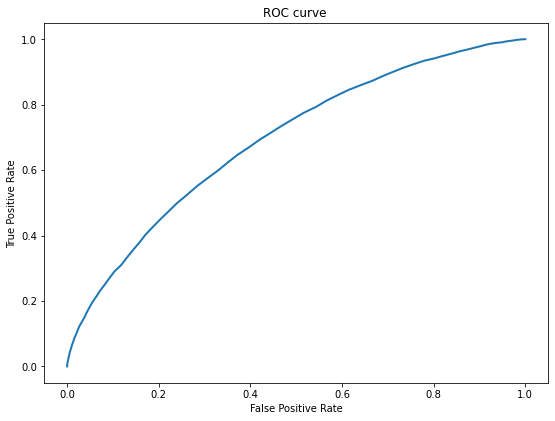

In [112]:
lp_1_fpr,lp_1_tpr,lp_1_auc = AUC_ROC(lp_1_model,X_test_s,y_test_s)
lp_1_metrics["AUC"] = round(lp_1_auc,4)

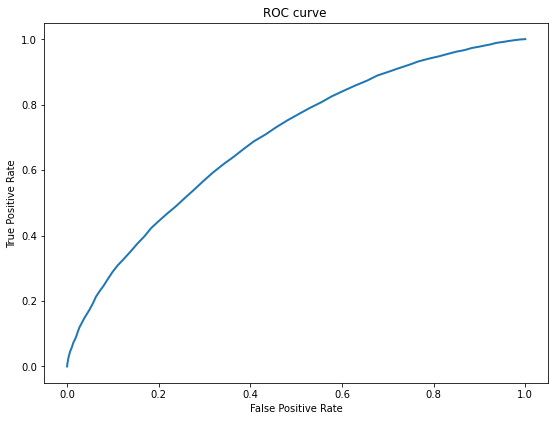

In [113]:
lp_2_fpr,lp_2_tpr,lp_2_auc = AUC_ROC(lp_2_model,X_test_s,y_test_s)
lp_2_metrics["AUC"] = round(lp_2_auc,4)

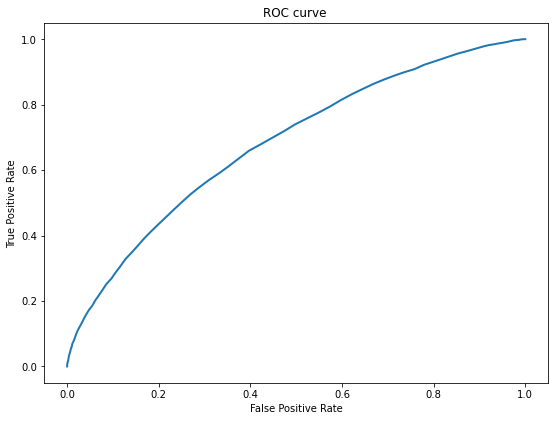

In [114]:
lp_3_fpr,lp_3_tpr,lp_3_auc = AUC_ROC(lp_3_model,X_test_s,y_test_s)
lp_3_metrics["AUC"] = round(lp_3_auc,4)

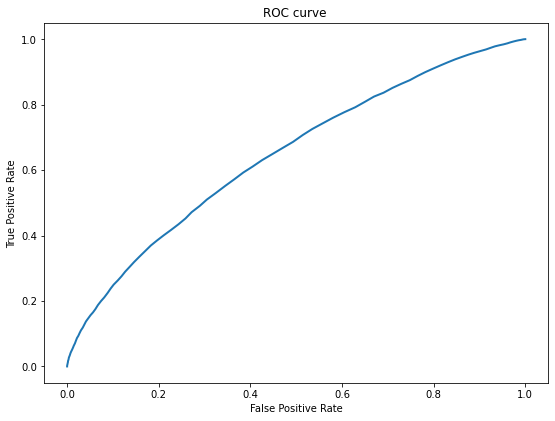

In [115]:
lp_4_fpr,lp_4_tpr,lp_4_auc = AUC_ROC(lp_4_model,X_test_s,y_test_s)
lp_4_metrics["AUC"] = round(lp_4_auc,4)

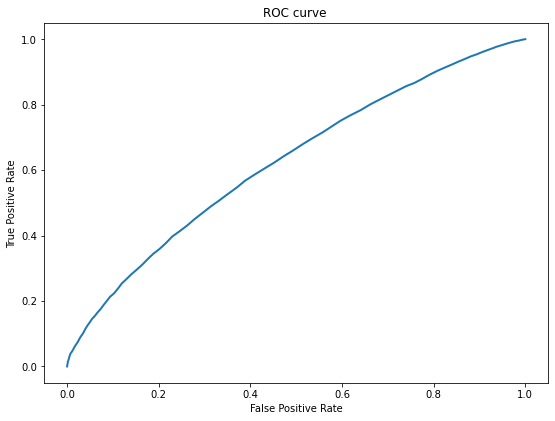

In [116]:
lp_5_fpr,lp_5_tpr,lp_5_auc = AUC_ROC(lp_5_model,X_test_s,y_test_s)
lp_5_metrics["AUC"] = round(lp_5_auc,4)

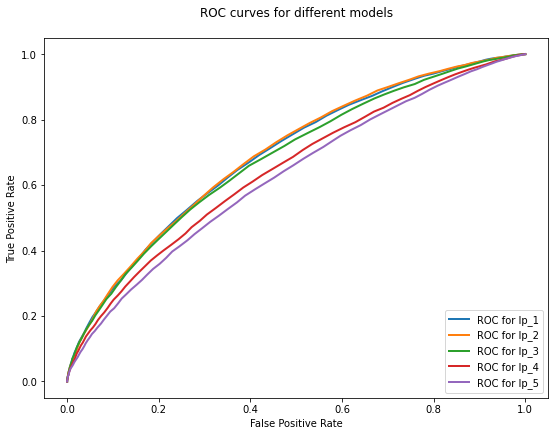

In [117]:
# Plotting ROC  curves of all the models to contrast each other
fig= plt.figure(figsize=(7,5))
axes=fig.add_axes([1,1,1,1])
RocCurveDisplay(fpr=lp_1_fpr,tpr=lp_1_tpr).plot(ax = axes,label = 'ROC for lp_1',lw = 2)
RocCurveDisplay(fpr=lp_2_fpr,tpr=lp_2_tpr).plot(ax = axes,label = 'ROC for lp_2',lw = 2)
RocCurveDisplay(fpr=lp_3_fpr,tpr=lp_3_tpr).plot(ax = axes,label = 'ROC for lp_3',lw = 2)
RocCurveDisplay(fpr=lp_4_fpr,tpr=lp_4_tpr).plot(ax = axes,label = 'ROC for lp_4',lw = 2)
RocCurveDisplay(fpr=lp_5_fpr,tpr=lp_5_tpr).plot(ax = axes,label = 'ROC for lp_5',lw = 2)
axes.set_title("ROC curves for different models\n",)
plt.show()

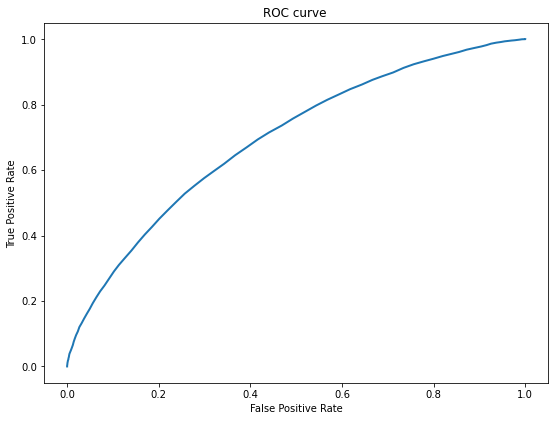

In [118]:
ls_1_fpr,ls_1_tpr,ls_1_auc = AUC_ROC(ls_1_model,X_test_s,y_test_s)
ls_1_metrics["AUC"] = round(ls_1_auc,4)

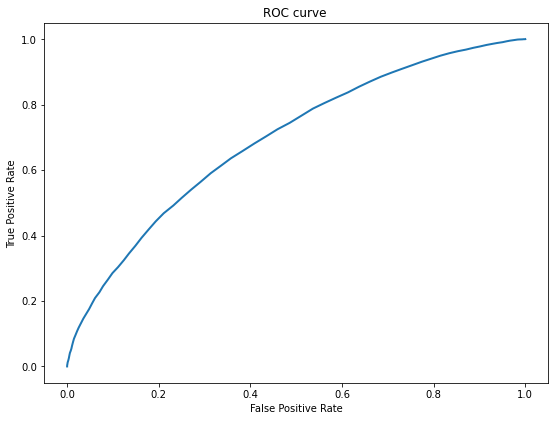

In [119]:
ls_2_fpr,ls_2_tpr,ls_2_auc = AUC_ROC(ls_2_model,X_test_s,y_test_s)
ls_2_metrics["AUC"] = round(ls_2_auc,4)

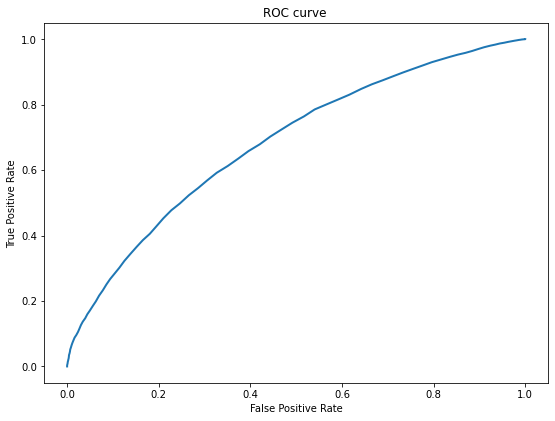

In [120]:
ls_3_fpr,ls_3_tpr,ls_3_auc = AUC_ROC(ls_3_model,X_test_s,y_test_s)
ls_3_metrics["AUC"] = round(ls_3_auc,4)

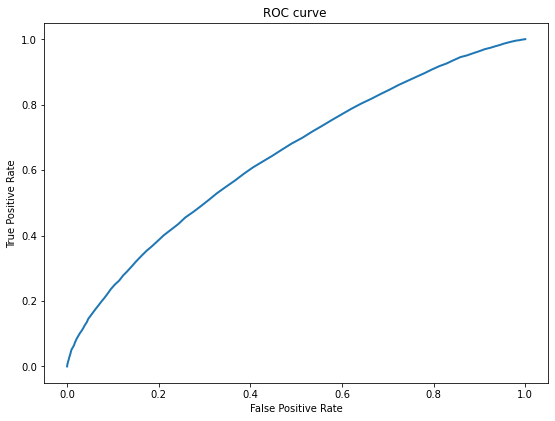

In [121]:
ls_4_fpr,ls_4_tpr,ls_4_auc = AUC_ROC(ls_4_model,X_test_s,y_test_s)
ls_4_metrics["AUC"] = round(ls_4_auc,4)

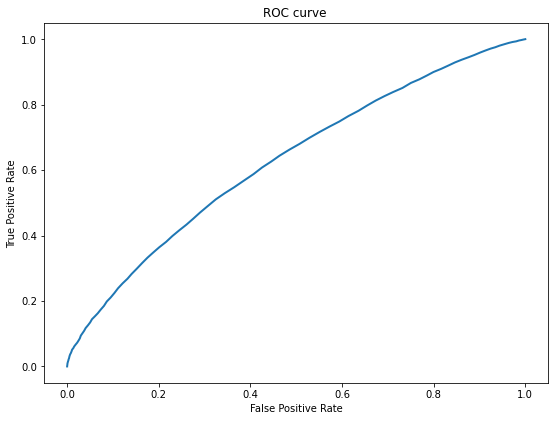

In [122]:
ls_5_fpr,ls_5_tpr,ls_5_auc = AUC_ROC(ls_5_model,X_test_s,y_test_s)
ls_5_metrics["AUC"] = round(ls_5_auc,4)

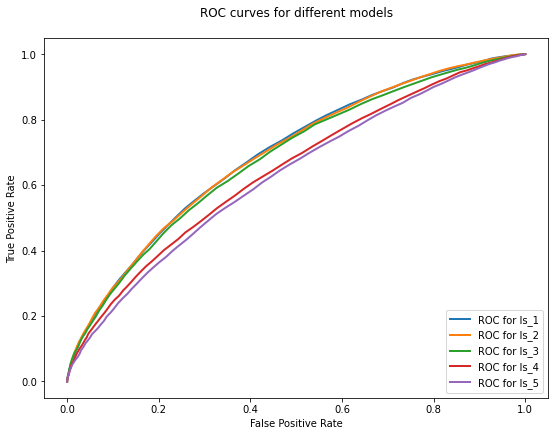

In [123]:
# Plotting ROC  curves of all the models to contrast each other
fig= plt.figure(figsize=(7,5))
axes=fig.add_axes([1,1,1,1])
RocCurveDisplay(fpr=ls_1_fpr,tpr=ls_1_tpr).plot(ax = axes,label = 'ROC for ls_1',lw = 2)
RocCurveDisplay(fpr=ls_2_fpr,tpr=ls_2_tpr).plot(ax = axes,label = 'ROC for ls_2',lw = 2)
RocCurveDisplay(fpr=ls_3_fpr,tpr=ls_3_tpr).plot(ax = axes,label = 'ROC for ls_3',lw = 2)
RocCurveDisplay(fpr=ls_4_fpr,tpr=ls_4_tpr).plot(ax = axes,label = 'ROC for ls_4',lw = 2)
RocCurveDisplay(fpr=ls_5_fpr,tpr=ls_5_tpr).plot(ax = axes,label = 'ROC for ls_5',lw = 2)
axes.set_title("ROC curves for different models\n",)
plt.show()

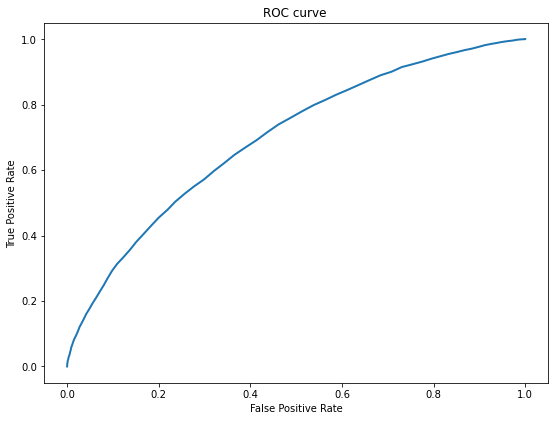

In [124]:
self_1_fpr,self_1_tpr,self_1_auc = AUC_ROC(self_1_model,X_test_s,y_test_s)
self_1_metrics["AUC"] = round(self_1_auc,4)

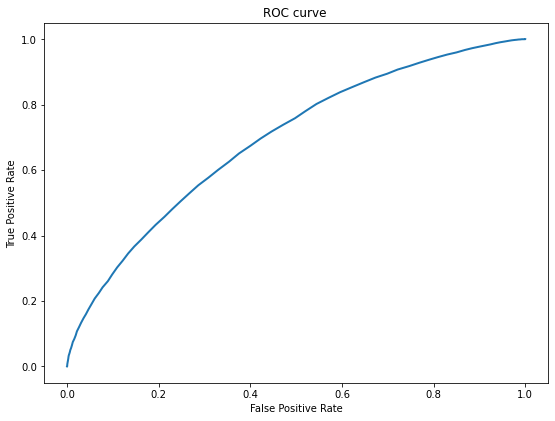

In [125]:
self_2_fpr,self_2_tpr,self_2_auc = AUC_ROC(self_2_model,X_test_s,y_test_s)
self_2_metrics["AUC"] = round(self_2_auc,4)

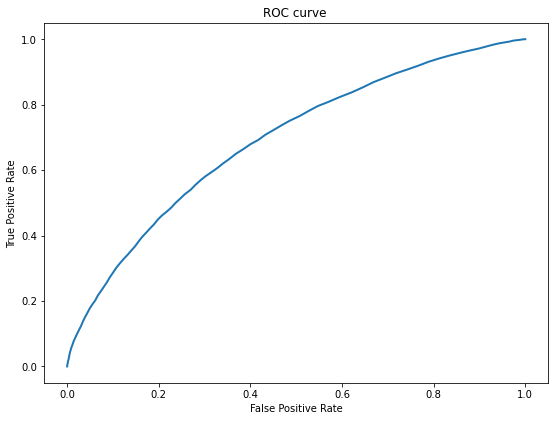

In [126]:
self_3_fpr,self_3_tpr,self_3_auc = AUC_ROC(self_3_model,X_test_s,y_test_s)
self_3_metrics["AUC"] = round(self_3_auc,4)

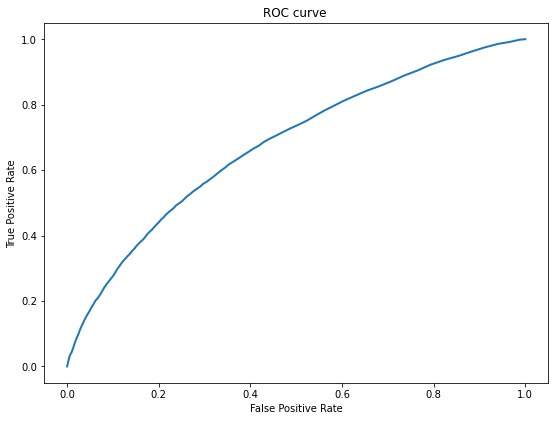

In [127]:
self_4_fpr,self_4_tpr,self_4_auc = AUC_ROC(self_4_model,X_test_s,y_test_s)
self_4_metrics["AUC"] = round(self_2_auc,4)

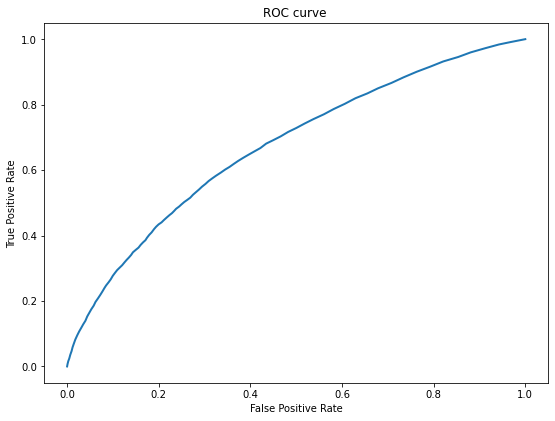

In [128]:
self_5_fpr,self_5_tpr,self_5_auc = AUC_ROC(self_5_model,X_test_s,y_test_s)
self_5_metrics["AUC"] = round(self_5_auc,4)

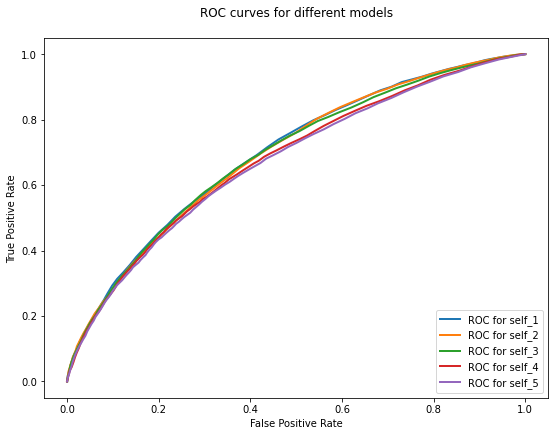

In [129]:
# Plotting ROC  curves of all the models to contrast each other
fig= plt.figure(figsize=(7,5))
axes=fig.add_axes([1,1,1,1])
RocCurveDisplay(fpr=self_1_fpr,tpr=self_1_tpr).plot(ax = axes,label = 'ROC for self_1',lw = 2)
RocCurveDisplay(fpr=self_2_fpr,tpr=self_2_tpr).plot(ax = axes,label = 'ROC for self_2',lw = 2)
RocCurveDisplay(fpr=self_3_fpr,tpr=self_3_tpr).plot(ax = axes,label = 'ROC for self_3',lw = 2)
RocCurveDisplay(fpr=self_4_fpr,tpr=self_4_tpr).plot(ax = axes,label = 'ROC for self_4',lw = 2)
RocCurveDisplay(fpr=self_5_fpr,tpr=self_5_tpr).plot(ax = axes,label = 'ROC for self_5',lw = 2)
axes.set_title("ROC curves for different models\n",)
plt.show()

In [130]:
s_data=np.c_[list(lp_1_metrics.values()),
            list(lp_2_metrics.values()),
            list(lp_3_metrics.values()),
            list(lp_4_metrics.values()),
            list(lp_5_metrics.values()),
            list(ls_1_metrics.values()),
            list(ls_2_metrics.values()),
            list(ls_3_metrics.values()),
            list(ls_4_metrics.values()),
            list(ls_5_metrics.values()),
            list(self_1_metrics.values()),
            list(self_2_metrics.values()),
            list(self_3_metrics.values()),
            list(self_4_metrics.values()),
            list(self_5_metrics.values())]

In [131]:
model_type = ["Label propagation","Label Spreading","Self-learning"]
e_metrics = list(lp_1_metrics.keys())
ind=["10 %","20 %","50 %","90 %","95 %"]
Index=pd.MultiIndex.from_product([model_type,ind])

In [132]:
d = pd.DataFrame(s_data.T,columns=e_metrics,index = Index)
d.index.set_names(["Algorithms","Unlabelled percentage"],inplace= True)

In [133]:
d.T

Algorithms            Label propagation                                  \
Unlabelled percentage              10 %            20 %            50 %   
f1_score                         0.5737          0.5673          0.5477   
Recall                           0.5236           0.513          0.4784   
Specificity                       0.739          0.7443          0.7676   
runtime                  00 min 12 secs  00 min 11 secs  00 min 11 secs   
accuracy                         0.6391          0.6371          0.6335   
AUC                              0.6921          0.6947          0.6816   

Algorithms                                            Label Spreading  \
Unlabelled percentage            90 %            95 %            10 %   
f1_score                       0.4967          0.4643          0.5786   
Recall                         0.4172           0.378          0.5279   
Specificity                    0.7731          0.7836          0.7433   
runtime                00 min 13 secs  00 min 12 secs  00 min 12 secs   
accuracy                        0.608          0.5955          0.6391   
AUC                            0.6462           0.626           0.694   

Algorithms                                                             \
Unlabelled percentage            20 %            50 %            90 %   
f1_score                        0.571          0.5485          0.4981   
Recall                         0.5151          0.4772           0.419   
Specificity                    0.7498          0.7725          0.7721   
runtime                00 min 11 secs  00 min 11 secs  00 min 13 secs   
accuracy                       0.6371          0.6335           0.608   
AUC                            0.6929          0.6834           0.644   

Algorithms                              Self-learning                  \
Unlabelled percentage            95 %            10 %            20 %   
f1_score                       0.4669           0.578          0.5638   
Recall                         0.3807          0.5265          0.5051   
Specificity                    0.7838          0.7446           0.752   
runtime                00 min 12 secs  00 min 27 secs  00 min 20 secs   
accuracy                       0.5955          0.6434          0.6375   
AUC                            0.6292          0.6968          0.6932   

Algorithms                                                             
Unlabelled percentage            50 %            90 %            95 %  
f1_score                       0.5338          0.5458          0.5338  
Recall                         0.4558          0.4716          0.4558  
Specificity                     0.782          0.7783           0.782  
runtime                00 min 16 secs  00 min 15 secs  00 min 10 secs  
accuracy                        0.641           0.636          0.6307  
AUC                            0.6911          0.6932          0.6724

### Satistical analysis

In [134]:
stat_data=np.c_[d.T["Label propagation"].loc['accuracy'].values,
d.T["Label Spreading"].loc['accuracy'].values,
d.T["Self-learning"].loc['accuracy'].values].T

In [135]:
s_ind=["10 %","20 %","50 %","90 %","95 %"]
s_model_type = ["Label propagation","Label Spreading","Self-learning"]
d1 = pd.DataFrame(stat_data.T,columns=s_model_type,index = s_ind )

In [136]:
d1

,Label propagation,Label Spreading,Self-learning
10 %,0.6391,0.6391,0.6434
20 %,0.6371,0.6371,0.6375
50 %,0.6335,0.6335,0.641
90 %,0.608,0.608,0.636
95 %,0.5955,0.5955,0.6307


In [137]:
def Friedman_test(Dataset,names):
    
    n,k=Dataset.shape
    
    Rank_table = Dataset.rank(axis=1,method="max",ascending=False)
    average_ranks=np.mean(Rank_table,axis=0)
    
    R_d = sum((average_ranks*n))/(n*k)
    ssd1 = n*sum((average_ranks - R_d)**2)
    ssd2 = sum(np.sum((Rank_table-R_d)**2).values)/(n*(k-1))
    
    F_stat = round(ssd1/ssd2,4) 
    
    return F_stat,average_ranks

In [138]:
Friedman_stat,avg_ranks = Friedman_test(Dataset=d1,names=s_model_type)

In [139]:
print("The Friednman Statistic obtained: {}".format(Friedman_stat))
print("The Average ranks from Friedman's Test:\n")
print(avg_ranks)

The Friednman Statistic obtained: 10.0
The Average ranks from Friedman's Test:

Label propagation    3.0
Label Spreading      3.0
Self-learning        1.0
dtype: float64


From the value of the Friedman statistic obtained which is 10, there is significant difference in the performance of the algorithms